# 07_05: Simulating data

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

In [2]:
import random
import faker

Sometimes you need to develop a data-analysis application before you have access to the data. In that case, a good approach is creating fake data with the right structure and realistic content. Then you can use that to populate your tables and test your algorithms. However, making these records by hand can be very time consuming.

Of course the Python ecosystem can help with that! The `faker` package is a popular library to generate random, realistic-looking fake data, such as names, addresses, dates, and more. Let's have a look at what it can do.

See https://faker.readthedocs.io/en/master

We start by creating an instance of the `Faker` class.

In [3]:
fake = faker.Faker()

Then we can call its methods to make up a person.

In [7]:
fake.name()

'Cameron Rocha'

In [8]:
fake.address()

'51001 Jennifer Drives Suite 296\nNorth Rachel, ME 49377'

In [9]:
fake.date_of_birth()

datetime.date(2008, 7, 4)

In [10]:
fake.city()

'East Luke'

In [12]:
fake.state_abbr()

'OH'

To make this a bit more interesting, we're going to create a database of imaginary musical performers, of their songs, and of the songs' rankings in a weekly billboard.

We start with an imaginary performer. In addition to name and date of birth, for which we specify minimum and maximum age, we put together city and state of birth using a Python f string, and a pick a random genre from a list that we provide using `random_element`. We could also use `random.choice`, but it's a bit more elegant to keep using `faker` methods.

In [4]:
music_genres = ['Rock', 'Pop', 'Jazz', 'Hip Hop', 'Country', 'Electronic', 'Blues', 
                'Reggae', 'Metal', 'Folk', 'Soul', 'R&B', 'Punk', 'Indie', 'Alternative']

In [378]:
def artist():
    return {'name': fake.name(),
            'dob': pd.to_datetime(fake.date_of_birth(minimum_age=16, maximum_age=80)), # from Python to pandas date object
            'birthplace': f'{fake.city()} {fake.state_abbr()}',
            'genre': fake.random_element(music_genres)}

Here's an artist, as a Python dictionary.

In [379]:
artist()

{'name': 'Tina Stewart',
 'dob': Timestamp('1985-03-02 00:00:00'),
 'birthplace': 'North Allison GA',
 'genre': 'Blues'}

We collect 100 random artists in a dataframe. The index is just a simple ordinal range, but we can use that just fine to link to other tables, so we'll name explicitly `artist_id`.

In [380]:
artists = pd.DataFrame([artist() for i in range(100)])
artists.index.name = 'artist_id'

In [383]:
artists

,name,dob,birthplace,genre
artist_id,,,,
0,Michelle Graham,1990-02-11,Raymondville KY,Blues
1,Kimberly Olson,1989-11-03,Christopherbury VT,Jazz
2,Stephanie Hale,1986-03-21,Port Connorhaven FM,Hip Hop
3,Dennis Sparks,1996-06-30,Nathanhaven PA,Pop
4,Taylor Turner,1992-05-23,New Timothy CA,Country
...,...,...,...,...
95,Suzanne Wagner,1948-05-09,Rodneyfort AL,R&B
96,Antonio Hernandez,1945-11-15,Richardmouth ME,Hip Hop
97,Mandy Burton,1949-06-08,West Melissa KS,Pop


Now for imaginary songs. We'll include a random `artist_id` picked from the index; a random title of up to twenty characters; the date of release in the last two years, and the appropriate genre for that artist.

In [184]:
def song():
    artist = fake.random_element(artists.index)
    
    return {'title': fake.text(max_nb_chars=20)[:-1], # skip the fin
            'release': pd.to_datetime(fake.past_date(start_date="-2y")),
            'artist_id': artist,
            'genre': artists.loc[artist, 'genre']}

Looks great. Yeah, the title could be more incisive, I agree.

In [185]:
song()

{'title': 'For inside herself',
 'release': Timestamp('2022-12-01 00:00:00'),
 'artist_id': 74,
 'genre': 'Punk'}

Let's try another... a bit better/just as bad.

In [186]:
song()

{'title': 'Home our three guy',
 'release': Timestamp('2023-01-02 00:00:00'),
 'artist_id': 60,
 'genre': 'Pop'}

So here's a table of 500 songs, and again we'll adopt the automatically generated index.

In [187]:
songs = pd.DataFrame([song() for i in range(500)])
songs.index.name = 'song_id'

In [188]:
songs

,title,release,artist_id,genre
song_id,,,,
0,Deal treatment keep,2024-08-02,50,R&B
1,Past guy letter,2024-04-13,10,R&B
2,Full three job our,2023-03-16,28,Blues
3,Image center thank,2023-01-24,43,R&B
4,Already anything,2024-09-02,39,Country
...,...,...,...,...
495,Cost hard hope low,2022-09-27,49,Pop
496,Send audience,2023-04-06,59,Rock
497,Thing animal,2023-09-13,53,Metal


Now we get into the weeds a bit. I'd like to create a history of plays (say on the radio, or on a streaming platform) for each songs. So we first set up a range of weeks from the release, for a randomized number of weeks. We use the pandas Timestamp and Timedelta objects, and the pandas function date_range. A frequency parameter of `W-MON` gets us a Monday every week. 

In [191]:
songs.loc[0].release

Timestamp('2024-08-02 00:00:00')

In [192]:
duration = np.random.randint(10, 50)

In [193]:
songs.loc[0].release + pd.Timedelta(weeks=duration)

Timestamp('2025-02-07 00:00:00')

In [194]:
t = pd.date_range(start=songs.loc[0].release,
                  end=songs.loc[0].release + pd.Timedelta(weeks=duration),
                  freq='W-MON')

We'll simulate a very simple history, declining linearly from a random initial value, multiplying by random coefficients between 0.8 and 1.2 to add some noise. But if you want to play with this you can get as fancy as you wish.

In [195]:
initial_plays = np.random.randint(500000, 1000000)

In [196]:
plays = initial_plays * np.linspace(1, 1/duration, duration) * np.random.uniform(0.8, 1.2, duration)

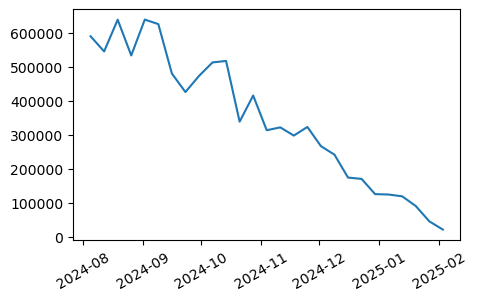

In [197]:
pp.figure(figsize=(5,3))
pp.plot(t, plays)
pp.xticks(rotation=30); # angled tick labels are more readable

Great! Let's put all of this together.

In [312]:
def history(song_id):
    duration = np.random.randint(10, 50)

    t = pd.date_range(start=songs.loc[song_id].release,
                      end=songs.loc[song_id].release + pd.Timedelta(weeks=duration),
                      freq='W-MON')

    initial_plays = np.random.randint(500000, 1000000)
    plays = initial_plays * np.linspace(1, 0, duration) * np.random.uniform(0.8, 1.2, duration)
    
    return pd.DataFrame({'song_id': song_id, 'plays': plays.astype(int), 'date': t[:duration]})

Looks good!

Let's make such a history for every song.

Ah, and the original index from every history will be useful, because it gives us the number of weeks since the release of a song. We turn it into a regular column with `reset_index`, then change its name.

In [330]:
histories = pd.concat([history(song_id) for song_id in songs.index], axis=0).reset_index().rename(columns={'index': 'week'})

In [331]:
histories

,week,song_id,plays,date
0,0,0,532148,2024-08-05
1,1,0,516859,2024-08-12
2,2,0,536810,2024-08-19
3,3,0,707906,2024-08-26
4,4,0,630020,2024-09-02
...,...,...,...,...
14556,22,499,127098,2024-10-21
14557,23,499,101714,2024-10-28
14558,24,499,64009,2024-11-04
14559,25,499,40399,2024-11-11


Last, we'll concentrate on the last year, downselecting our table using a boolean condition.

In [332]:
histories = histories[(histories.date > pd.Timestamp.today() - pd.Timedelta(weeks=52)) &
                      (histories.date <= pd.Timestamp.today())]

We will also sort by week of the year and by number of plays, largest first.

In [335]:
histories = histories.sort_values(['date', 'plays'], ascending=[True, False])

In [336]:
histories

,week,song_id,plays,date
10551,5,356,914858,2023-09-18
8717,3,298,889235,2023-09-18
12662,1,434,861902,2023-09-18
10498,0,354,853999,2023-09-18
11814,3,402,852520,2023-09-18
...,...,...,...,...
9511,47,323,12915,2024-09-09
8342,13,286,0,2024-09-09
9200,42,313,0,2024-09-09
11145,9,375,0,2024-09-09


If we want the top ten of every week, we can group by date and take the first ten records, then set the date as index.

`groupby` is a powerful method to split data into groups, apply a function to each group, and then combine the results back into a single DataFrame.

In [337]:
topten = histories.groupby('date').head(10).set_index('date')
topten

,week,song_id,plays
date,,,
2023-09-18,5,356,914858
2023-09-18,3,298,889235
2023-09-18,1,434,861902
2023-09-18,0,354,853999
2023-09-18,3,402,852520
...,...,...,...
2024-09-09,3,159,766831
2024-09-09,3,33,766118
2024-09-09,1,113,741397


In [340]:
topten.loc['2024-09-09']

,week,song_id,plays
date,,,
2024-09-09,1,133,963318
2024-09-09,2,332,889085
2024-09-09,0,56,827170
2024-09-09,0,209,811642
2024-09-09,7,200,768662
2024-09-09,3,159,766831
2024-09-09,3,33,766118
2024-09-09,1,113,741397
2024-09-09,4,124,694890


With another `groupby` we can compute the rank of each top-ten song, every week.

In [341]:
topten['rank'] = topten.groupby('date').plays.rank(ascending=False)

In [342]:
topten

,week,song_id,plays,rank
date,,,,
2023-09-18,5,356,914858,1.0
2023-09-18,3,298,889235,2.0
2023-09-18,1,434,861902,3.0
2023-09-18,0,354,853999,4.0
2023-09-18,3,402,852520,5.0
...,...,...,...,...
2024-09-09,3,159,766831,6.0
2024-09-09,3,33,766118,7.0
2024-09-09,1,113,741397,8.0


Finally, we merge with the song and artists tables, using the `song_id` and `artist_id`, to get titles and performers. Remember that those ids are actually in the index of those tables, hence the options given to merge.

In [343]:
songs.head()

,title,release,artist_id,genre
song_id,,,,
0,Deal treatment keep,2024-08-02,50,R&B
1,Past guy letter,2024-04-13,10,R&B
2,Full three job our,2023-03-16,28,Blues
3,Image center thank,2023-01-24,43,R&B
4,Already anything,2024-09-02,39,Country


In [344]:
artists.head()

,name,dob,birthplace,genre
artist_id,,,,
0,Shawn Taylor,1980-11-07,Bassbury NC,Folk
1,Christian Stone,1995-01-04,Lake Bradberg DE,Soul
2,Bradley Bailey,1952-08-17,Powellton IL,Rock
3,Jennifer Vasquez,1951-01-28,Calhounport VT,Country
4,Jennifer Rogers,1981-02-24,North Luismouth OH,Blues


In [357]:
merged = topten.merge(songs, left_on='song_id', right_index=True) \
               .merge(artists.name, left_on='artist_id', right_index=True)
merged

,week,song_id,plays,rank,title,release,artist_id,genre,name
date,,,,,,,,,
2023-09-18,5,356,914858,1.0,Sit outside then,2023-08-13,0,Folk,Shawn Taylor
2023-09-18,3,298,889235,2.0,Her operation,2023-08-23,51,Reggae,Curtis Chen
2023-09-18,1,434,861902,3.0,Trial improve his,2023-09-06,39,Country,Nancy Nash
2023-09-18,0,354,853999,4.0,Certainly assume,2023-09-18,90,Hip Hop,Renee Hunter
2023-09-18,3,402,852520,5.0,Oil because,2023-08-23,6,Rock,Robert Barry
...,...,...,...,...,...,...,...,...,...
2024-09-09,3,159,766831,6.0,Both age policy,2024-08-14,91,Rock,Janet Williamson
2024-09-09,3,33,766118,7.0,Property our best,2024-08-14,0,Folk,Shawn Taylor
2024-09-09,1,113,741397,8.0,Remain wind man see,2024-08-29,74,Punk,James Jones


Excellent! Is there any performer who has been at the top of the billboard more than once?

In [358]:
first = merged.query('rank == 1').groupby('name').title.count().sort_values(ascending=False).head()
first

name
Logan Martin         5
Wanda Park           4
Renee Hunter         3
Richard Hendricks    3
John Page            3
Name: title, dtype: int64

Here it is! (change) Logan Martin took 5 first spots with "Another increase" and "Call meeting!".

In [366]:
merged[(merged['rank'] == 1) & (merged['name'] == first.index[0])]

,week,song_id,plays,rank,title,release,artist_id,genre,name
date,,,,,,,,,
2023-10-09,0,140,1108304,1.0,Another increase,2023-10-06,79,Alternative,Logan Martin
2023-10-16,1,140,1094319,1.0,Another increase,2023-10-06,79,Alternative,Logan Martin
2024-01-29,0,314,1075464,1.0,Call meeting,2024-01-28,79,Alternative,Logan Martin
2024-02-12,2,314,1101413,1.0,Call meeting,2024-01-28,79,Alternative,Logan Martin
2024-03-18,7,314,948515,1.0,Call meeting,2024-01-28,79,Alternative,Logan Martin


In [367]:
merged

,week,song_id,plays,rank,title,release,artist_id,genre,name
date,,,,,,,,,
2023-09-18,5,356,914858,1.0,Sit outside then,2023-08-13,0,Folk,Shawn Taylor
2023-09-18,3,298,889235,2.0,Her operation,2023-08-23,51,Reggae,Curtis Chen
2023-09-18,1,434,861902,3.0,Trial improve his,2023-09-06,39,Country,Nancy Nash
2023-09-18,0,354,853999,4.0,Certainly assume,2023-09-18,90,Hip Hop,Renee Hunter
2023-09-18,3,402,852520,5.0,Oil because,2023-08-23,6,Rock,Robert Barry
...,...,...,...,...,...,...,...,...,...
2024-09-09,3,159,766831,6.0,Both age policy,2024-08-14,91,Rock,Janet Williamson
2024-09-09,3,33,766118,7.0,Property our best,2024-08-14,0,Folk,Shawn Taylor
2024-09-09,1,113,741397,8.0,Remain wind man see,2024-08-29,74,Punk,James Jones


Let's save our work! Not all the pandas output formats can save multiple tables together. Pickles are always an option, and so is one format that we did not discuss in detail---HDF5.

With HDF5, the `DataFrame` method `to_hdf` keeps appending tables to the same file; you give a _key_, which is how the individual tables are found. (In fact HDF5 files can have a hierarchical structure similar to a file system.)

In [384]:
merged.to_hdf('songtables.h5', key='topten')
artists.to_hdf('songtables.h5', key='artists')
songs.to_hdf('songtables.h5', key='songs')

To read the tables back into pandas we'd use `HDFStore` and a simple dictionary syntax.

In [386]:
h5 = pd.HDFStore('songtables.h5')

In [387]:
h5.keys()

['/artists', '/songs', '/topten']

In [390]:
h5['/artists']

,name,dob,birthplace,genre
artist_id,,,,
0,Michelle Graham,1990-02-11,Raymondville KY,Blues
1,Kimberly Olson,1989-11-03,Christopherbury VT,Jazz
2,Stephanie Hale,1986-03-21,Port Connorhaven FM,Hip Hop
3,Dennis Sparks,1996-06-30,Nathanhaven PA,Pop
4,Taylor Turner,1992-05-23,New Timothy CA,Country
...,...,...,...,...
95,Suzanne Wagner,1948-05-09,Rodneyfort AL,R&B
96,Antonio Hernandez,1945-11-15,Richardmouth ME,Hip Hop
97,Mandy Burton,1949-06-08,West Melissa KS,Pop


That's all folks!